In [1]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import warnings
import copy
from functools import reduce
from typing import List

import numpy as np
import torch as th
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from absa import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, \
                parsed_reviews_dump_path, PROGRESSBAR_COLUMNS_NUM
from absa.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from absa.preprocess.spell_check import spell_check, load_checked_reviews
from absa.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from absa.sentence.aspect.classifier import AspectClassifier as SentenceAspectClassifier
from absa.target.aspect.classifier import AspectClassifier as TargetAspectClassifier
from absa.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [2]:
word2vec = get_embeddings()

train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin
INFO:root:Upload dependency trees from dump.
INFO:root:Upload dependency trees from dump.


### display

In [ ]:
SCORE_NAME = 'f1'
PARAMETER_DECIMAL_LEN = 5
SCORE_DECIMAL_LEN = 3


def display_score(parameter_values: List,
                  train_values: List[float],
                  val_values: List[float],
                  parameter_name='Epoch',
                  score_name=SCORE_NAME) -> float:

    max_param, max_acc = [(parameter_values[index], val)
                          for index, val in enumerate(val_values) if val == max(val_values)][0]

    plt.figure(figsize=(10, 10))
    plt.grid(True, alpha=0.3)
    plt.xlim(left=min(parameter_values), right=max(parameter_values))

    # train
    plt.plot(parameter_values, train_values, color='blue')
    # validation
    plt.plot(parameter_values,
             val_values,
             color='orange')

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f'Dependence of {score_name} from {parameter_name}')
    plt.xlabel(f'{parameter_name}')
    plt.ylabel(score_name.capitalize())
    if isinstance(max_param, (int, )):
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}} when {parameter_name}={max_param}'
        ])
    else:
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}}' +
            f' when {parameter_name}={max_param:.{PARAMETER_DECIMAL_LEN}f}'
        ])
    plt.legend(['Train', 'Validation'])

In [ ]:
kf = KFold(n_splits=splits_number)

# Sentence Aspect Classification

### Train

In [3]:
num_epoch = 40

classifier = SentenceAspectClassifier(word2vec=word2vec)
sentence_train_f1_history, sentence_val_f1_history = classifier.fit(train_sentences=train_sentences, 
                                                  val_sentences=test_sentences,
                                                  num_epoch=num_epoch)

100%|███████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


In [ ]:
%store sentence_train_f1_history sentence_val_f1_history

In [ ]:
%store -r

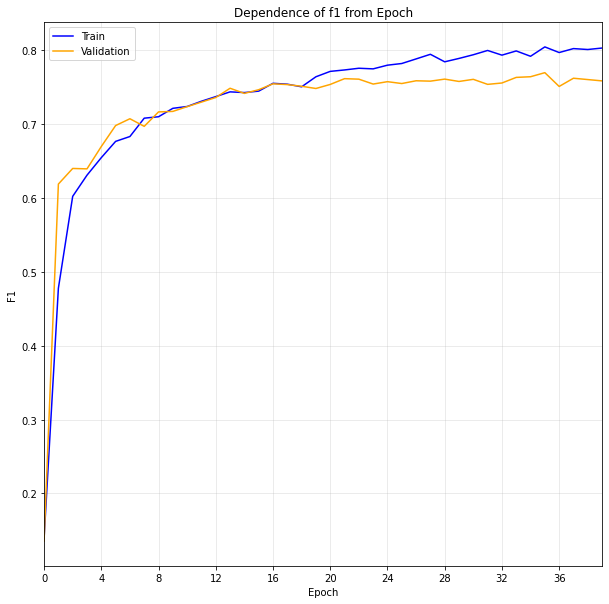

In [4]:
display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=sentence_train_f1_history,
              val_values=senetence_val_f1_history)

### Predict

In [5]:
test_sentences_pred = copy.deepcopy(test_sentences)
for sentence in test_sentences_pred:
    sentence.reset_targets()

test_sentences_pred = classifier.predict(test_sentences_pred)
classifier.score(sentences=test_sentences, sentences_pred=test_sentences_pred)

Score(precision=0.74375, recall=0.7727272727272727, f1=0.7579617834394904)

# Target Aspect Classification

### Train

In [6]:
classifier = TargetAspectClassifier.load_model()

In [7]:
num_epoch = 40

classifier = TargetAspectClassifier(word2vec=word2vec)
target_train_f1_history, target_val_f1_history = classifier.fit(train_sentences=train_sentences, 
                                            val_sentences=test_sentences,
                                            num_epoch=num_epoch)

100%|███████████████████████████████████████████████████████████████| 40/40 [01:03<00:00,  1.58s/it]


In [ ]:
%store target_train_f1_history target_val_f1_history

In [ ]:
%store -r

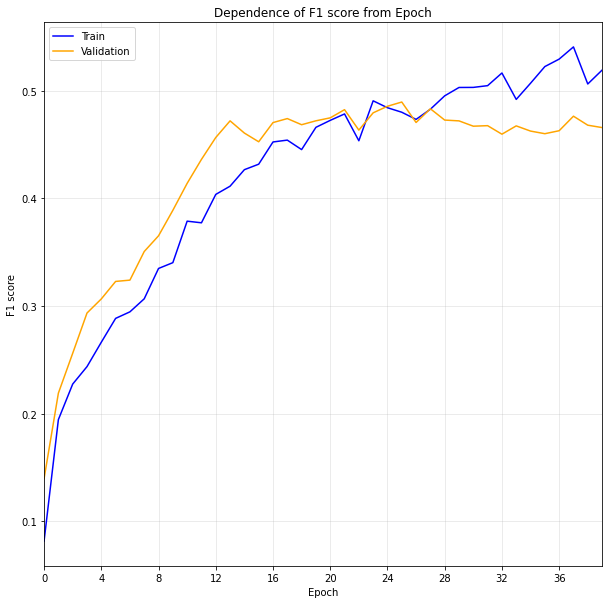

In [8]:
display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=target_train_f1_history,
              val_values=target_val_f1_history,
              score_name='F1 score')

### Predict

In [9]:
test_sentences_pred = classifier.predict(test_sentences_pred)
classifier.score(sentences=test_sentences, sentences_pred=test_sentences_pred)

Score(precision=0.6123076923076923, recall=0.36886005560704355, f1=0.4603817235396183)